# Hyperparameter tuning

#### Hyperparameters = the settings of an algorithm that can be adjusted to optimize performance
While model parameters are learned during training, hyperparameters must be set before training.<br>
Hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations and evaluate the performance of each model.<br>
For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings. We then compare all of the models, select the best one, train it on the full training set, and then evaluate on the testing set.<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from sklearn.metrics import roc_curve, roc_auc_score


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv("./data-tergul8/Titanic_final.csv", index_col=0)
df.head()

,Survived,Pclass,SibSp,Parch,Sex_cat,Embarked_cat,Title_cat,Is_Alone,Fare_min_max,Age_norm
0,0,3,1,0,1,2,2,0,0.014151,-0.517838
1,1,1,1,0,0,0,3,0,0.139129,0.615799
2,1,3,0,0,0,2,1,1,0.015478,-0.234429
3,1,1,1,0,0,2,3,0,0.103644,0.403242
4,0,3,0,0,1,2,2,1,0.015713,0.403242


In [3]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

## Random Forest
Generate a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [4]:
rf = RandomForestClassifier(random_state = 4)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}


We will adjust the following set of hyperparameters:
- n_estimators: number of trees in the foreset
- max_features: max number of features considered for splitting a node
- max_depth: max number of levels in each decision tree
- min_samples_split: min number of data samples in a node before the node is split
- min_samples_leaf: min number of data samples allowed in a leaf node
- max_samples: the number/precent of samples to draw from X to train each base estimator. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

Random forest decumentation: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Random Hyperparameter Grid
Define a grid of hyperparameter ranges, and <b>randomly</b> sample from the grid, performing K-Fold CV with each combination of values.<br>


In [5]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]

max_features = [ 2, 5, 7, 10]

max_depth = [int(x) for x in range(2, 9)]

min_samples_split = [5, 10, 15, 20]

min_samples_leaf = [3, 5, 10, 15]

max_samples = [0.1, 0.3, 0.5, 0.7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
pprint(random_grid)

{'max_depth': [2, 3, 4, 5, 6, 7, 8],
 'max_features': [2, 5, 7, 10],
 'max_samples': [0.1, 0.3, 0.5, 0.7],
 'min_samples_leaf': [3, 5, 10, 15],
 'min_samples_split': [5, 10, 15, 20],
 'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}


On each iteration, the algorithm will choose a different combination of the features.<br>
Altogether, there are $  15 \cdot 5 \cdot 7 \cdot 5 \cdot 5 \cdot 5 = 65,625 $ settings! <br>
However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [6]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5,
                                verbose=2, random_state = 42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'max_features': [2, 5, 7, 10],
                                        'max_samples': [0.1, 0.3, 0.5, 0.7],
                                        'min_samples_leaf': [3, 5, 10, 15],
                                        'min_samples_split': [5, 10, 15, 20],
                                        'n_estimators': [10, 31, 52, 73, 94,
                                                         115, 136, 157, 178,
                                                         200]},
                   random_state=42, verbose=2)

The most important arguments in RandomizedSearchCV are:
- n_iter: controls the number of different combinations to try
- cv: the number of folds to use for cross validation.

More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time.<br>
Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

We can view the best hyperparameters from fitting the random search:

In [7]:
rf_random.best_params_

{'n_estimators': 73,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_samples': 0.7,
 'max_features': 5,
 'max_depth': 6}

#### Compare the base model with the best random search model.

In [8]:
# Fit and predict with the base model
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# Calculate accuracy of the base model
rf_accuracy = metrics.accuracy_score(y_test, rf_y_pred)
print('Base model accuracy: {:0.2f}%'.format(rf_accuracy * 100))

# Fit and predict with the optimized model
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)
random_y_pred = best_random.predict(X_test)

# Calculate accuracy of the optimized model
random_accuracy = metrics.accuracy_score(y_test, random_y_pred)
print('Optimized model accuracy: {:0.2f}%'.format(random_accuracy * 100))

# Calculate improvement
improvement = 100 * (random_accuracy - rf_accuracy) / rf_accuracy
print('Improvement: {:0.2f}%'.format(improvement))

Base model accuracy: 79.37%
Optimized model accuracy: 82.06%
Improvement: 3.39%


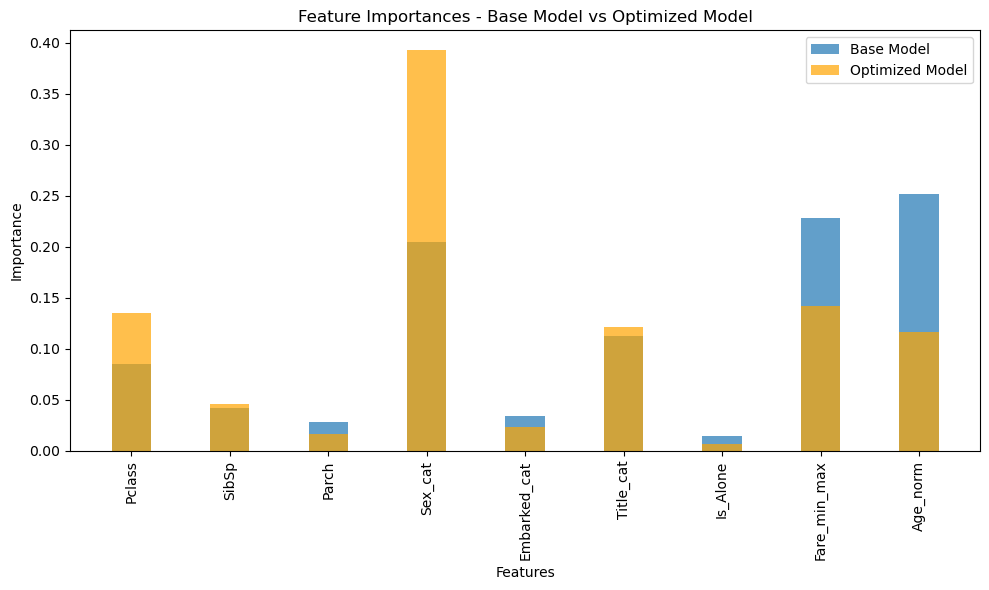

In [9]:
# Extract feature importances from both models
base_importances = rf.feature_importances_
optimized_importances = best_random.feature_importances_

# Create a bar plot to visualize feature importances
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(base_importances))
bar_width = 0.4

ax.bar(x, base_importances, label='Base Model', width=bar_width, alpha=0.7)
ax.bar(x, optimized_importances, label='Optimized Model', width=bar_width, alpha=0.7, color='orange')

ax.set_xticks(x)
ax.set_xticklabels(X.columns, rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importances - Base Model vs Optimized Model')
ax.legend()

# Show the improvement percentage below the plot
plt.tight_layout()
plt.show()


The maximum and minimum depth for all trees (estimators) in the "forest".

In [10]:
random_depth = [best_random.estimators_[i].get_depth() for i in range(best_random.get_params()['n_estimators'])]
print('Random max depth: ', max(random_depth))
print('Random min depth: ', min(random_depth))

Random max depth:  6
Random min depth:  6


In [11]:
rf_depth = [rf.estimators_[i].get_depth() for i in range(rf.get_params()['n_estimators'])]
print('Base max depth: ', max(rf_depth))
print('Base min depth: ', min(rf_depth))

Base max depth:  24
Base min depth:  13


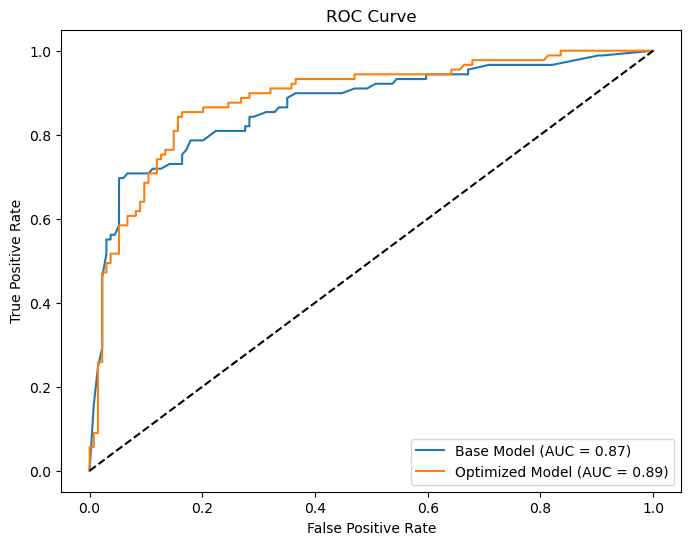

In [12]:
base_proba = rf.predict_proba(X_test)[:, 1]

random_proba = best_random.predict_proba(X_test)[:, 1]

# Calculate AUC scores
base_auc = roc_auc_score(y_test, base_proba)
random_auc = roc_auc_score(y_test, random_proba)

# Create ROC curves
base_fpr, base_tpr, _ = roc_curve(y_test, base_proba)
random_fpr, random_tpr, _ = roc_curve(y_test, random_proba)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(base_fpr, base_tpr, label='Base Model (AUC = {:.2f})'.format(base_auc))
plt.plot(random_fpr, random_tpr, label='Optimized Model (AUC = {:.2f})'.format(random_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()




### Grid Search 
A method that, instead of sampling randomly from a distribution, evaluates all combinations we define.<br>
Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try.

In [13]:
rf_random.best_params_

{'n_estimators': 73,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_samples': 0.7,
 'max_features': 5,
 'max_depth': 6}

In [14]:
param_grid = {'n_estimators': [70],
              'min_samples_split': [5, 10],
              'min_samples_leaf': [3, 5],
              'max_features': [3, 5],
              'max_depth': [5, 6],
              'max_samples': [ 0.5, 0.7]}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose=2)

This will try out $ 1 \cdot 2 \cdot 2 \cdot 2 \cdot 2 \cdot 2 = 32 $ combinations of settings. 

In [15]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'max_depth': 6,
 'max_features': 5,
 'max_samples': 0.5,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 70}

In [16]:
# Fit and predict with the new optimized model
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
grid_y_pred = best_grid.predict(X_test)

# Calculate accuracy of the optimized model
random_accuracy = metrics.accuracy_score(y_test, random_y_pred)
print('Random method model accuracy: {:0.2f}%'.format(random_accuracy * 100))

grid_accuracy = metrics.accuracy_score(y_test, grid_y_pred)
print('Grid method model accuracy = {:0.2f}%'.format(grid_accuracy*100))

# Calculate improvement
improvement = 100 * (grid_accuracy - random_accuracy) / random_accuracy
print('Improvement: {:0.2f}%'.format(improvement))

Random method model accuracy: 82.06%
Grid method model accuracy = 82.51%
Improvement: 0.55%


## Visualization

#### Training Curves
We can perform grid search over only one parameter to observe the effects of changing that parameter on performance. We will look at training time, training set accuracy, and testing set accuracy.

In [17]:
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 500, 10)]}

tree_grid_search = GridSearchCV(best_grid, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 5,
                                scoring = 'accuracy')
tree_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=6, max_features=5,
                                              max_samples=0.5,
                                              min_samples_leaf=3,
                                              min_samples_split=5,
                                              n_estimators=70, random_state=4),
             n_jobs=-1,
             param_grid={'n_estimators': [1, 56, 111, 167, 222, 278, 333, 389,
                                          444, 500]},
             scoring='accuracy', verbose=2)

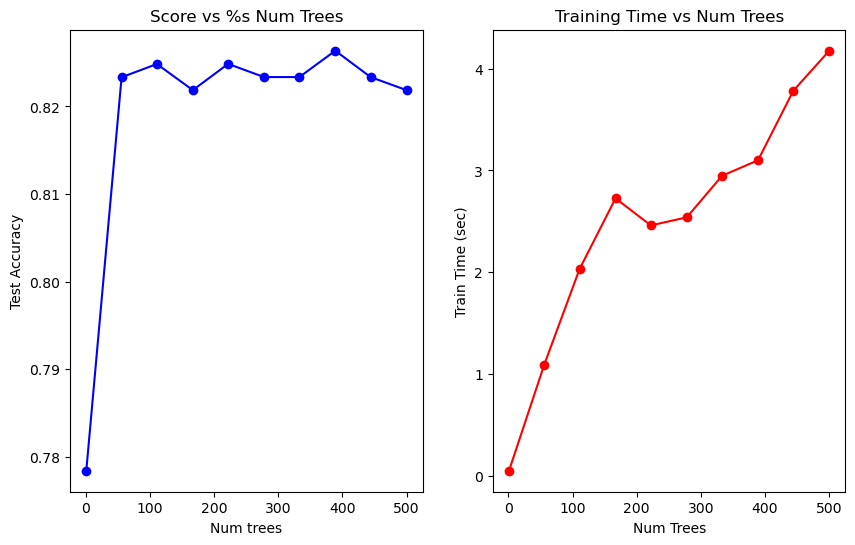

In [18]:
test_scores = tree_grid_search.cv_results_['mean_test_score']
train_time = tree_grid_search.cv_results_['mean_fit_time']
param_values = list(tree_grid_search.cv_results_['param_n_estimators'])

plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.plot(param_values, test_scores, 'bo-', label = 'test')
plt.xlabel('Num trees')
plt.ylabel('Test Accuracy')
plt.title('Score vs %s Num Trees' )

plt.subplot(122)
plt.plot(param_values, train_time, 'ro-')
plt.xlabel('Num Trees')
plt.ylabel('Train Time (sec)')
plt.title('Training Time vs Num Trees')

plt.show()

### Visualizing One Tree in the Forest

In [19]:
tree = best_grid.estimators_[15]

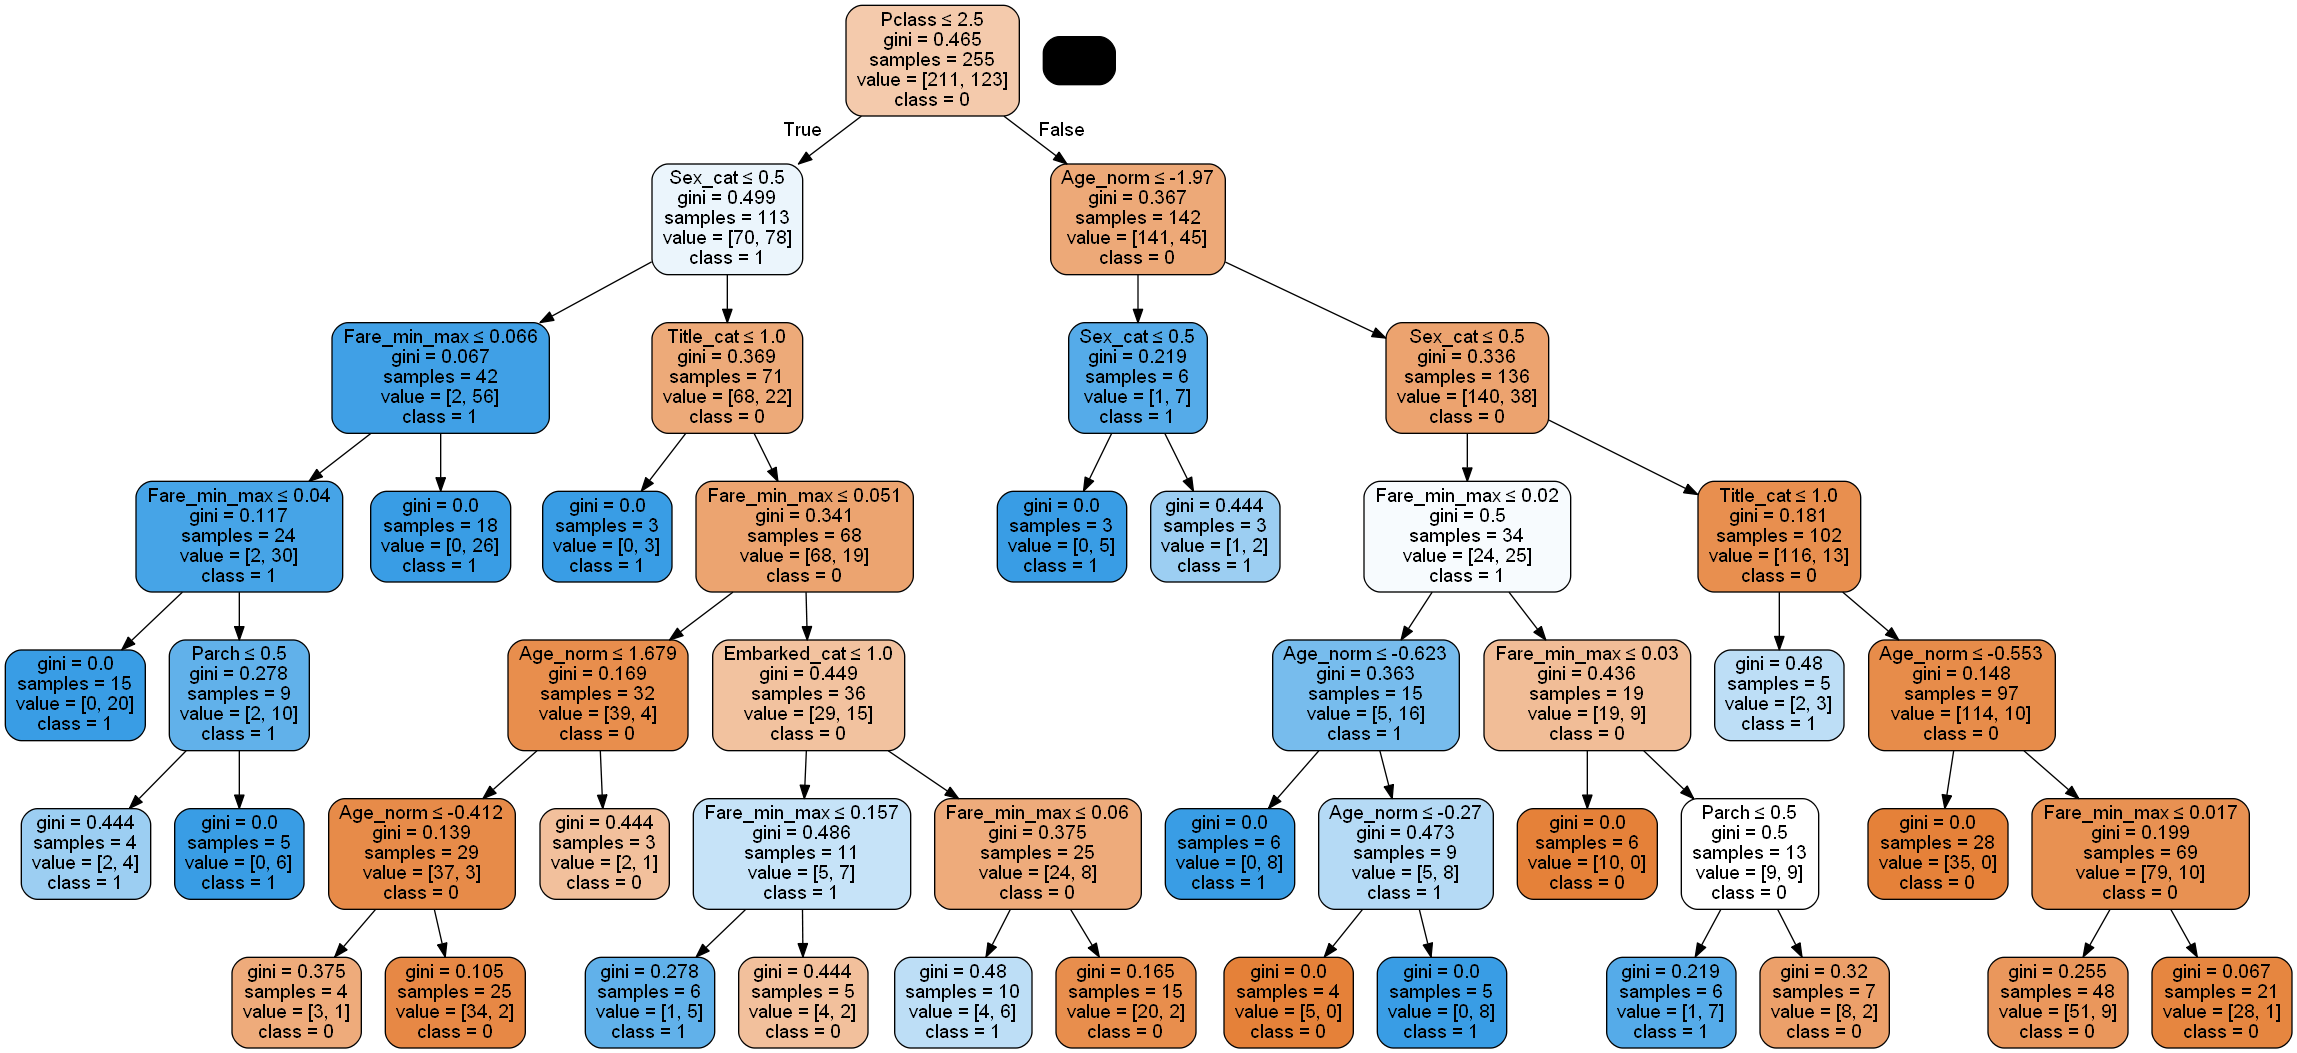

In [20]:
dot = export_graphviz(tree, filled=True, rounded=True, 
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
Image(graph.create_png())